In [61]:
'''オートエンコーダを用いた異常検知
オートエンコーダは、入力層と出力層に同じデータを用いて、教師なし学習で訓練したモデル
1.正常データのみを用いて、オートエンコーダを訓練
2.訓練したモデルに異常値を含んだデータを投入して、予測する。
3.1で学習したモデルに学習データに無いパターンである異常データを入力すると、波形を復元しきれずに入力データの形状と乖離が発生。
    -＞復元しきれずに乖離が発生したデータを異常とみなすことで異常検知を行う

今回はcsvファイルとtxtファイルの2種類と、周期的なデータと異常時には大きく数値が振れるようなデータを用意して異常検知のテストを行う
'''


'オートエンコーダを用いた異常検知\nオートエンコーダは、入力層と出力層に同じデータを用いて、教師なし学習で訓練したモデル\n1.正常データのみを用いて、オートエンコーダを訓練\n2.訓練したモデルに異常値を含んだデータを投入して、予測する。\n3.1で学習したモデルに学習データに無いパターンである異常データを入力すると、波形を復元しきれずに入力データの形状と乖離が発生。\n    -＞復元しきれずに乖離が発生したデータを異常とみなすことで異常検知を行う\n\n今回はcsvファイルとtxtファイルの2種類と、周期的なデータと異常時には大きく数値が振れるようなデータを用意して異常検知のテストを行う\n'

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [63]:
mode = 0  # 0:センサーデータ / 1:心電図データ

if mode == 0:
    df_data = pd.read_csv("../data/Sensor2.csv", header=None, delimiter='\t', parse_dates=True)
else:
    df = pd.read_csv('../data/sample_data.txt', header=None, delimiter='\t', parse_dates=True)
    # 2列目に心電図データが格納されているため2
    df_data = df.iloc[:, 2].values
    df_data = df_data[:5000]
    df_data = df_data.reshape(len(df_data), -1)
df_data.shape


(250, 1)

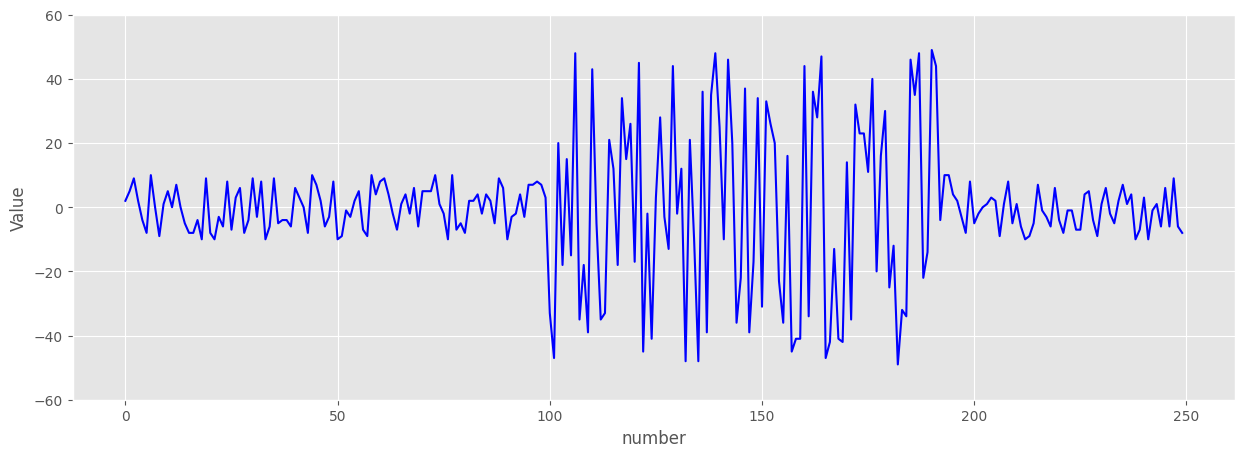

In [64]:
# 読み込んだデータをプロット
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.xlabel('number')
plt.ylabel('Value')
plt.plot(df_data, color='b')
plt.ylim(-60, 60) if mode == 0 else plt.ylim()

plt.show()


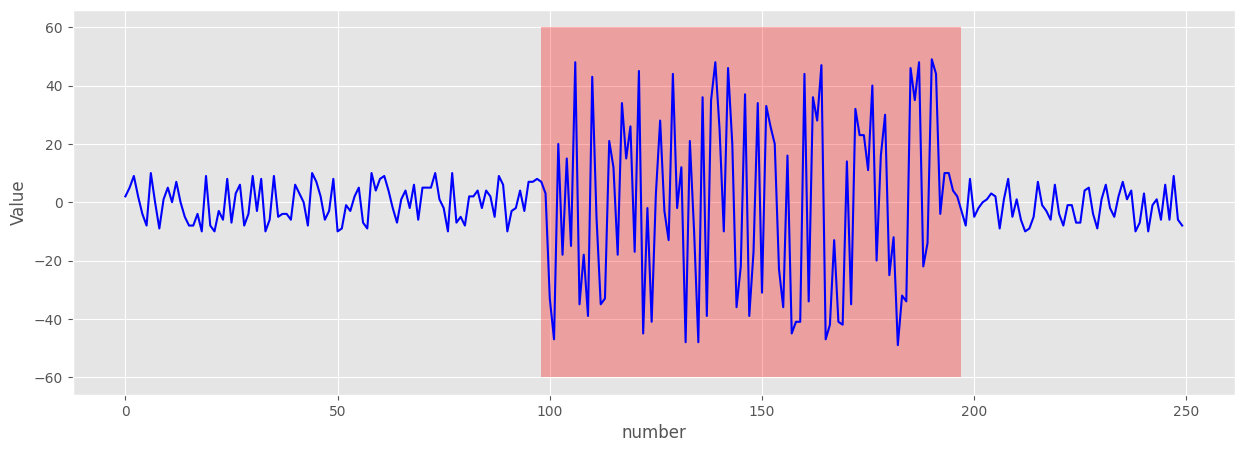

In [65]:
# 異常として検知したい個所をマーク
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.xlabel('number')
plt.ylabel('Value')
plt.plot(df_data, color='b')
if mode == 0:
    x = np.arange(98, 198)
    area_x, area_y = -60, 60
else:
    x = np.arange(4200, 4600)
    area_x, area_y = 2, 8
plt.fill_between(x, area_x, area_y, facecolor='r', alpha=.3)

plt.show()


In [66]:
# データセットを正規化し、学習データとテストデータに分割
if mode == 0:
    # 正常データ(0-100)
    normal_cycle = df_data[:100]
    # 異常データ(98-198)
    abnormal_cycle = df_data[100:200]

    # 標準化
    scaler = StandardScaler()
    train_data = scaler.fit_transform(normal_cycle)
    test_data = (abnormal_cycle - normal_cycle.mean()) / normal_cycle.std()
else:
    # 平均値を0にする
    df_data_mean = df_data.mean()
    df_dataset = (df_data - df_data_mean)

    # データセットの最大値で割り、-1～1の範囲に収まるように正規化する
    df_dataset_max = np.abs(df_dataset).max()
    df_dataset = df_dataset / df_dataset_max

    train_data = df_dataset[:4000]
    test_data = df_dataset[:5000]


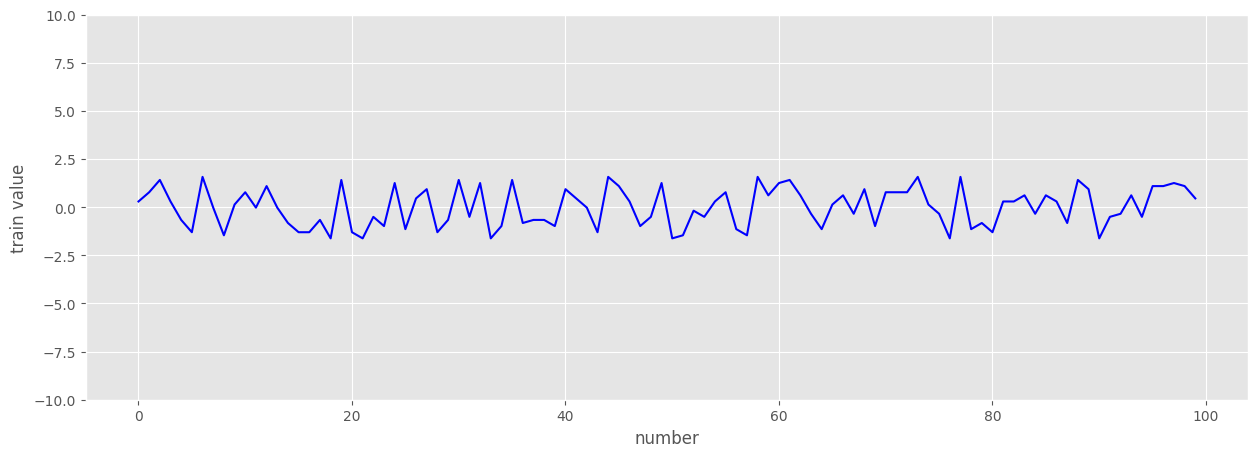

In [67]:
# 平常データ（学習データ）
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.xlabel('number')
plt.ylabel('train value')
plt.plot(train_data, color='b')

if mode == 0:
    plt.ylim(-10, 10)

plt.show()


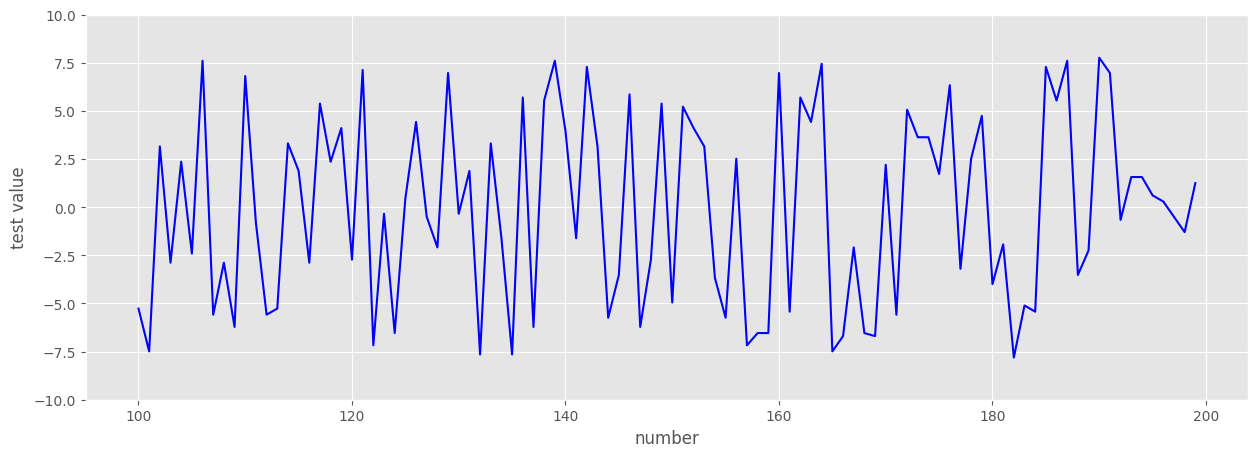

In [68]:
# 異常データ（テストデータ）
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.xlabel('number')
plt.ylabel('test value')
plt.plot(test_data, color='b')

if mode == 0:
    plt.ylim(-10, 10)

plt.show()


In [69]:
# データセット作成
def create_dataset(array, time_steps):
    dataset_list = []

    for i in range(0, len(array) - time_steps + 1):
        dataset_list.append(array[i: (i + time_steps)])

    return np.stack(dataset_list)


In [70]:
# time_steps：データをtime_steps毎に1ずつスライドさせる（数値は適当）
if mode == 0:
    time_steps = 3

else:
    time_steps = 128

x_train = create_dataset(train_data, time_steps)
x_test = create_dataset(test_data, time_steps)


In [71]:
model = tf.keras.initializers.Initializer()
if mode == 0:
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
            ),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
            ),
            tf.keras.layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
            ),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
            ),
            tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )


else:
    model = tf.keras.Sequential(
        [
            # 入力層
            tf.keras.layers.InputLayer(input_shape=(x_train.shape[1], x_train.shape[2])),

            # エンコード層
            tf.keras.layers.Conv1D(
                filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),

            # デコード層
            tf.keras.layers.Conv1DTranspose(
                filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Conv1DTranspose(
                filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
            ),

            # 出力層
            tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 3, 32)             256       
                                                                 
 dropout_6 (Dropout)         (None, 3, 32)             0         
                                                                 
 conv1d_7 (Conv1D)           (None, 3, 16)             3600      
                                                                 
 conv1d_transpose_9 (Conv1DT  (None, 3, 16)            1808      
 ranspose)                                                       
                                                                 
 dropout_7 (Dropout)         (None, 3, 16)             0         
                                                                 
 conv1d_transpose_10 (Conv1D  (None, 3, 32)            3616      
 Transpose)                                           

In [72]:
# 訓練
history = model.fit(
    x_train,  # 学習データ
    x_train,  # 教師データ
    validation_split=0.1,  # 検証データ比率(学習データの1割を検証データとして使用する)
    epochs=100,  # エポック数
    batch_size=8,  # バッチサイズ
    callbacks=[
        # コールバック指定
        # 5回検証Lossの改善が無かったら学習を打ち切るよう設定
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/100
11/11 [==============================] - 1s 31ms/step - loss: 1.0024 - val_loss: 0.9615
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9645 - val_loss: 0.9219
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8527 - val_loss: 0.8306
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6590 - val_loss: 0.6652
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.3734 - val_loss: 0.4356
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2299 - val_loss: 0.3044
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1978 - val_loss: 0.2276
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1285 - val_loss: 0.1328
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1019 - val_loss: 0.0472
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0951 - val_loss: 0.0339
Epoch 11

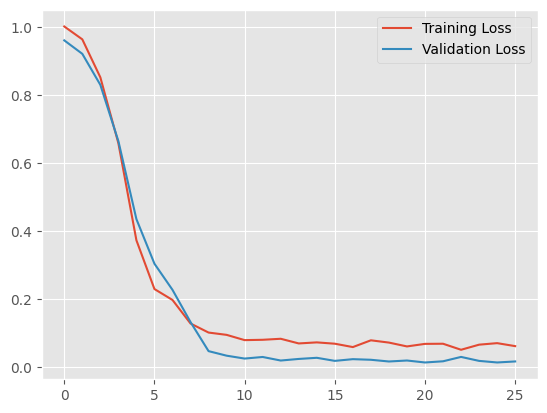

In [73]:
# 学習曲線を確認
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


1/1 [==============================] - 0s 159ms/step


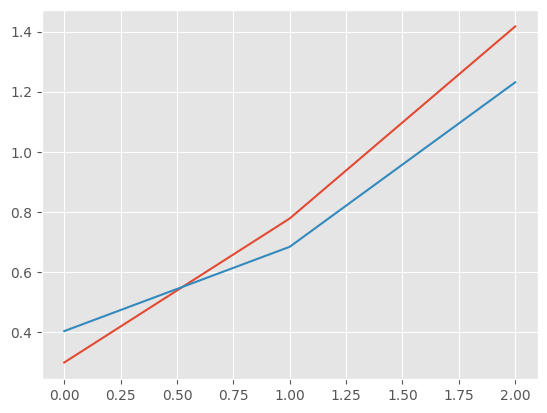

In [74]:
# 訓練したモデルで推論
# 入力に対して予測値も同じものが出てくるような想定
# 入力データ(temp_data)が復元できていればいいモデル
temp_data = x_train[0]
temp_data = temp_data.reshape(-1, time_steps, 1)

temp_result = model.predict(temp_data)

plt.plot(temp_data[0])
plt.plot(temp_result[0])
plt.show()


4/4 [==============================] - 0s 3ms/step


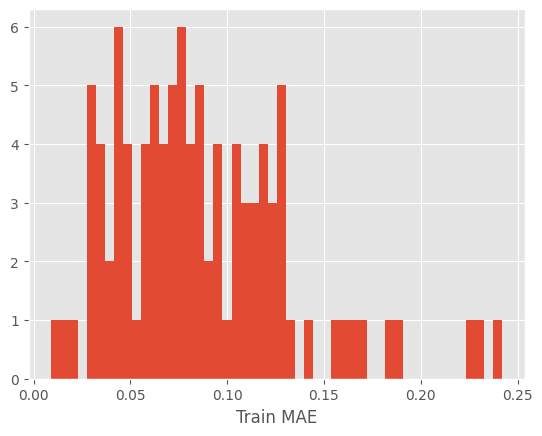

0.02419801709228577


In [75]:
# モデルに学習データを入力し、予測値を取得
# オートエンコーダでの異常検知は、入力データが復元できたか否かで判断する。
# 復元できたか否かは入力データの値と推論値のMAE(Mean Absolute Error：平均絶対誤差)を算出し、復元できたか確認します。
# まずは学習データ(正常データ)を推論し、MAEを算出します。
x_train_pred = model.predict(x_train)
train_abs = np.abs(x_train_pred - x_train)
train_mae = np.mean(train_abs, axis=1)
train_mae = train_mae.reshape(-1)

# MAEの分布をヒストグラムで確認
plt.hist(train_mae, bins=50)
plt.xlabel("Train MAE")
plt.show()

# 正常データでのMAEの最大値を確認(閾値)
# この値より大きいMAEの場合、異常データとして扱います。
threshold = np.max(train_mae) if mode == 1 else np.max(train_mae) / 10

print(threshold)


4/4 [==============================] - 0s 3ms/step


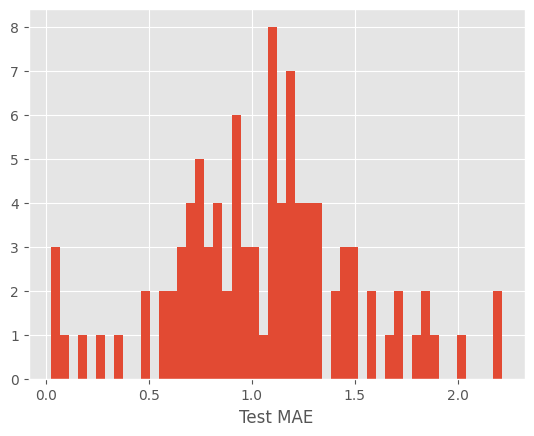

In [76]:
# 異常波形の入った検証用のデータ(x_test)を入力し、予測。
x_test_pred = model.predict(x_test)

test_abs = np.abs(x_test_pred - x_test)
test_mae = np.mean(test_abs, axis=1)
test_mae = test_mae.reshape(-1)

# MAEの分布をヒストグラム
plt.hist(test_mae, bins=50)
plt.xlabel("Test MAE")
plt.show()


In [77]:
# 得られた結果と入力の値における絶対誤差平均を計算し、絶対誤差平均が閾値以上になっているインデックスを抽出
anomaly_result = test_mae > threshold

# 異常検知個数
print("異常検知個数: ", np.sum(anomaly_result))

# 異常検知したインデックス
print("異常検知インデックス: ", np.where(anomaly_result))


異常検知個数:  97
異常検知インデックス:  (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97]),)


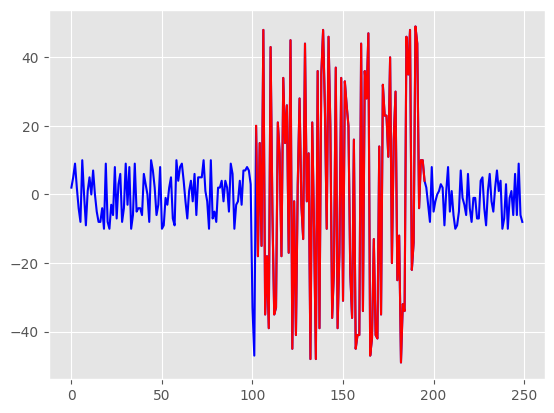

In [78]:
if mode == 0:
    # 異常と判定されたインデックスを含んでいるデータセットに対して赤色でプロット
    anomalous_data_indices = []
    for data_idx in range(time_steps - 1, len(x_test) - time_steps + 1):
        if np.all(anomaly_result[data_idx - time_steps + 1: data_idx]):
            anomalous_data_indices.append(data_idx)

    df_subset = abnormal_cycle.iloc[anomalous_data_indices]
    fig, ax = plt.subplots()
    df_data.plot(legend=False, ax=ax, color="b")
    df_subset.plot(legend=False, ax=ax, color="r")
    plt.show()

else:
    plt.figure(figsize=(15, 5))
    plt.plot(test_data, color="b")

    for index, anomaly in enumerate(anomaly_result):
        if anomaly:
            x = np.arange(index, index + time_steps)
            y1 = [-1] * len(x)
            y2 = [1] * len(x)
            plt.fill_between(x, y1, y2, facecolor='r', alpha=.3)
